# Match Woods-Saxon parametrization

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ January 16, 2024

This notebook determines the best "matching" parametrization to VMC and CVMC momentum distributions.

_Last update:_ January 17, 2024

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Imports from scripts
from scripts.figures import (
    label_kvnn, label_lambda, label_nucleus, line_styles, set_rc_parameters
)
from scripts.integration import momentum_mesh
from scripts.momentum_distributions import MomentumDistribution
from scripts.tools import convert_number_to_string, replace_periods

from test_momentum_distribution_script_v9 import load_momentum_distribution
from test_momentum_distribution_script_v9 import compute_normalization

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
vmc_directory = '../data/vmc/momentum_distributions/'

### Table of $\langle r_p \rangle$ values

| Nucleus   | AV18 (fm) | AV18 + UIX (fm) | AV18 + UX (fm) | Universal (fm) | Seminole (fm) | Match (fm) |
| --------- | --------- | --------------- | -------------- | -------------- | ------------- | ---------- |
| $^4$He    | 1.5157    |                 | 1.4404         | 2.299213       | 1.838522      | 1.874378   |
| $^{12}$C  |           | 2.3484          | 2.3522         | 2.668064       | 2.423350      | 2.476660   |
| $^{16}$O  | 2.3990    | 2.6161          |                | 2.760983       | 2.559766      | 2.831951   |
| $^{40}$Ca | 3.2641    | 3.5306          |                | 3.468719       | 3.326706      | 3.716340   |

In [5]:
def load_momentum_distribution(
    nucleus_name, nucleon, kvnn, lamb, kvnn_hard=None, lambda_m=None,
    parametrization='Match'
):
    """Load and return the momentum distribution along with the isolated
    contributions.
    """
    
    directory = f"../data/momentum_distributions/{nucleus_name}/"

    if kvnn_hard is not None:
        file_name = replace_periods(
            f"{nucleus_name}_{nucleon}_momentum_distribution_kvnn_{kvnn}_lamb"
            f"_{lamb}_kvnn_hard_{kvnn_hard}_lambda_m_{lambda_m}"
        )
    else:
        file_name = replace_periods(
            f"{nucleus_name}_{nucleon}_momentum_distribution_kvnn_{kvnn}_lamb"
            f"_{lamb}"
        )
    
    ### TESTING
    if parametrization != '':
        file_name += f'_{parametrization}'
    
    data = np.loadtxt(directory + file_name + '.txt')
    
    q_array = data[:, 0]
    q_weights = data[:, 1]
    n_array = data[:, 2]
    n_errors = data[:, 3]
    I_array = data[:, 4]
    delta_U_array = data[:, 5]
    delta_U_errors = data[:, 6]
    delta_U2_array = data[:, 7]
    delta_U2_errors = data[:, 8]
    
    return (q_array, q_weights, n_array, n_errors, I_array, delta_U_array,
            delta_U_errors, delta_U2_array, delta_U2_errors)

In [6]:
def compare_ws(
        nucleus_name, Z, x_limits=(0.0,6.0), y_limits=(1e-4,1e3), y_scale='log',
        show_vmc=False
):
    
    # AV18 + UIX
    if nucleus_name == 'O16' or nucleus_name == 'Ca40':
        filename = f"{nucleus_name}_single_nucleon_av18_uix.txt"
        vmc_label = "AV18 + UIX"
    # AV18 + UX
    elif nucleus_name == 'He4' or nucleus_name == 'C12':
        filename = f"{nucleus_name}_single_nucleon_av18_ux.txt"
        vmc_label = "AV18 + UX"

    data = np.loadtxt(vmc_directory + filename)
    q_vmc = data[:,0]
    n_vmc = data[:,1] / Z
    n_errors_vmc = data[:,2] / Z

    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'linear':
        ax.set_yscale('linear')
    elif y_scale == 'log':
        ax.set_yscale('log')
        
    if y_scale == 'linear':
        if show_vmc:
            ax.errorbar(
                q_vmc, n_vmc * q_vmc ** 2, yerr=n_errors_vmc * q_vmc ** 2, 
                color='black', label=vmc_label, ls='', marker='.'
            )
    elif y_scale == 'log':
        if show_vmc:
            ax.errorbar(q_vmc, n_vmc, yerr=n_errors_vmc, color='black',
                        label=vmc_label, ls='', marker='.')
        
    # Load data from file
    q_s, qw_s, nq_s, _, nqipm_s, _, _, _, _ = load_momentum_distribution(
        nucleus_name, 'proton', 6, 1.5, parametrization='Seminole')
    q_u, qw_u, nq_u, _, nqipm_u, _, _, _, _ = load_momentum_distribution(
        nucleus_name, 'proton', 6, 1.5, parametrization='Universal')
    q_m, qw_m, _, _, nqipm_m, _, _, _, _ = load_momentum_distribution(
        nucleus_name, 'proton', 6, 1.5, parametrization='Match')

    # Multiply by factor (2\pi)^3 / Z to compare to VMC data
    nq_s *= (2*np.pi) ** 3 / Z
    nqipm_s *= (2*np.pi) ** 3 / Z
    nq_u *= (2*np.pi) ** 3 / Z
    nqipm_u *= (2*np.pi) ** 3 / Z
    nqipm_m *= (2*np.pi) ** 3 / Z
    
    # Print value at peak
    seminole_ipm_max = np.max(q_s ** 2 * nqipm_s)
    seminole_max = np.max(q_s ** 2 * nq_s)
    seminole_ratio = seminole_max / seminole_ipm_max
    universal_ipm_max = np.max(q_u ** 2 * nqipm_u)
    universal_max = np.max(q_u ** 2 * nq_u)
    universal_ratio = universal_max / universal_ipm_max
    match_ipm_max = np.max(q_m ** 2 * nqipm_m)
    print("Peak of full Seminole over peak of Seminole IPM = "
          f"{seminole_ratio:.5f}")
    print("Peak of full Universal over peak of Universal IPM = "
          f"{universal_ratio:.5f}")
    print(f"Peak of Match IPM = {match_ipm_max:.5f}")
    print(f"Projected peak of Match = {match_ipm_max*0.87574:.5f}")
    vmc_max = np.max(q_vmc ** 2 * n_vmc)
    print(f"Peak of VMC = {vmc_max:.5f}")
    
    q_index_vmc = np.fabs(q_vmc ** 2 * n_vmc - vmc_max).argmin()
    print(f"Position of VMC peak = {q_vmc[q_index_vmc]:.5f}")
    q_index_match = np.fabs(q_m ** 2 * nqipm_m - match_ipm_max).argmin()
    print(f"Position of Match peak = {q_m[q_index_match]:.5f}")

    # Add to plot
    if y_scale == 'linear':
        
        ax.plot(q_s, nqipm_s * q_s ** 2, label='Seminole IPM', color='red',
                ls='dotted', lw=2.0)
        ax.plot(q_u, nqipm_u * q_u ** 2, label='Universal IPM', color='blue',
                ls='dotted', lw=2.0)
        ax.plot(q_m, nqipm_m * q_m ** 2, label='Match IPM', color='green',
                ls='dotted', lw=2.0)
        
        ax.plot(q_s, nq_s * q_s ** 2, label='Seminole', color='red', ls='solid',
                lw=2.0)
        ax.plot(q_u, nq_u * q_u ** 2, label='Universal', color='blue',
                ls='solid', lw=2.0)

    else:
        
        ax.plot(q_s, nqipm_s, label='Seminole IPM', color='red', ls='dotted',
                lw=2.0)
        ax.plot(q_u, nqipm_u, label='Universal IPM', color='blue', ls='dotted',
                lw=2.0)
        ax.plot(q_m, nqipm_m, label='Match IPM', color='green', ls='dotted',
                lw=2.0)
        
        ax.plot(q_s, nq_s, label='Seminole', color='red', ls='solid', lw=2.0)
        ax.plot(q_u, nq_u, label='Universal', color='blue', ls='solid', lw=2.0)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = r"$q^2 n(q) / Z$ [fm]"
    elif y_scale == 'log':
        ylabel = r"$n(q) / Z$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Add nucleus label
    if y_scale == 'log':
        nucleus_label_loc = 'lower left'
    elif y_scale == 'linear':
        nucleus_label_loc = 'upper left'
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc=nucleus_label_loc,
                     prop=dict(size=18), frameon=False)
    )
        
    # Set legend in first panel only
    ax.legend(loc='upper right', fontsize=9, frameon=False);

Peak of full Seminole over peak of Seminole IPM = 0.86473
Peak of full Universal over peak of Universal IPM = 0.88675
Peak of Match IPM = 26.53879
Projected peak of Match = 23.24108
Peak of VMC = 24.88587
Position of VMC peak = 0.70000
Position of Match peak = 0.66886


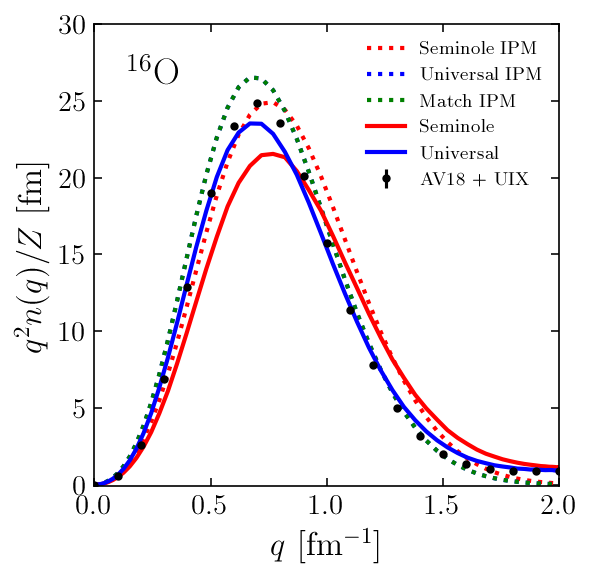

In [7]:
compare_ws('O16', 8, x_limits=(0,2), y_limits=(-0.1, 30), y_scale='linear',
           show_vmc=True)

Peak of full Seminole over peak of Seminole IPM = 0.89264
Peak of full Universal over peak of Universal IPM = 0.93697
Peak of Match IPM = 24.18736
Projected peak of Match = 21.18183
Peak of VMC = 22.06800
Position of VMC peak = 0.60000
Position of Match peak = 0.62033


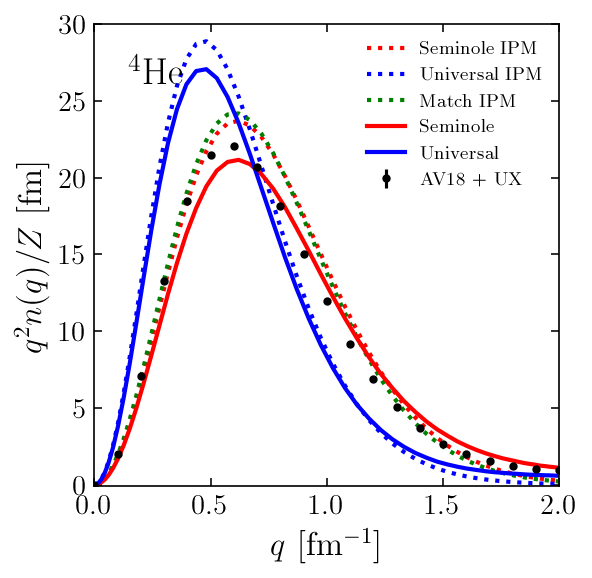

In [8]:
compare_ws('He4', 2, x_limits=(0,2), y_limits=(-0.1, 30), y_scale='linear',
           show_vmc=True)

Peak of full Seminole over peak of Seminole IPM = 0.88169
Peak of full Universal over peak of Universal IPM = 0.90131
Peak of Match IPM = 24.46672
Projected peak of Match = 21.42649
Peak of VMC = 21.66208
Position of VMC peak = 0.70000
Position of Match peak = 0.71828


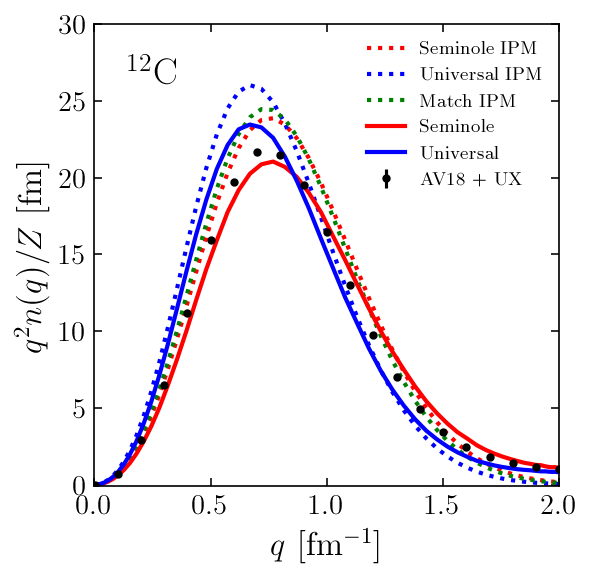

In [9]:
compare_ws('C12', 6, x_limits=(0,2), y_limits=(-0.1, 30), y_scale='linear',
           show_vmc=True)

Peak of full Seminole over peak of Seminole IPM = 0.85971
Peak of full Universal over peak of Universal IPM = 0.86787
Peak of Match IPM = 29.18888
Projected peak of Match = 25.56187
Peak of VMC = 25.22560
Position of VMC peak = 0.80000
Position of Match peak = 0.76846


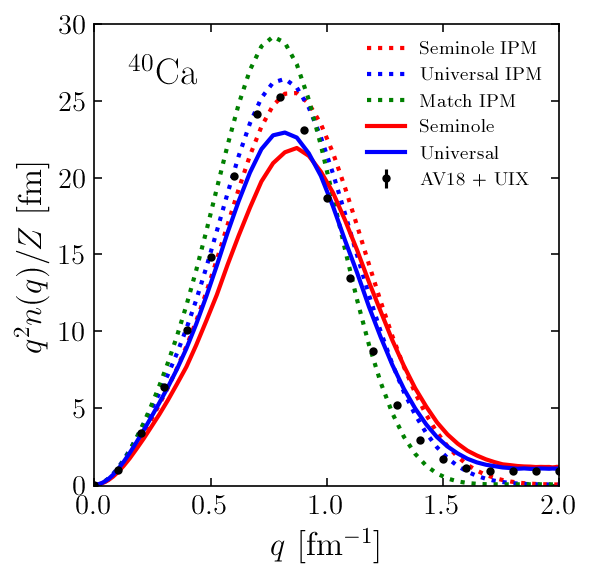

In [10]:
compare_ws('Ca40', 20, x_limits=(0,2), y_limits=(-0.1, 30), y_scale='linear',
           show_vmc=True)

In [11]:
def compare_vmc_match(
        nucleus_name, Z, x_limits=(0.0,6.0), y_limits=(1e-4,1e3), y_scale='log'
):
    
    # AV18 + UIX
    if nucleus_name == 'O16' or nucleus_name == 'Ca40':
        filename = f"{nucleus_name}_single_nucleon_av18_uix.txt"
        vmc_label = "AV18 + UIX"
    # AV18 + UX
    elif nucleus_name == 'He4' or nucleus_name == 'C12':
        filename = f"{nucleus_name}_single_nucleon_av18_ux.txt"
        vmc_label = "AV18 + UX"

    data = np.loadtxt(vmc_directory + filename)
    q_vmc = data[:,0]
    n_vmc = data[:,1] / Z
    n_errors_vmc = data[:,2] / Z

    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'linear':
        ax.set_yscale('linear')
    elif y_scale == 'log':
        ax.set_yscale('log')
        
    if y_scale == 'linear':
        ax.errorbar(q_vmc, n_vmc * q_vmc ** 2, yerr=n_errors_vmc * q_vmc ** 2, 
                    color='black', label=vmc_label, ls='', marker='.')
    elif y_scale == 'log':
        ax.errorbar(q_vmc, n_vmc, yerr=n_errors_vmc, color='black',
                    label=vmc_label, ls='', marker='.')
        
    # Load data from file
    q_m, qw_m, nq_m, _, nqipm_m, _, _, _, _ = load_momentum_distribution(
        nucleus_name, 'proton', 6, 1.5, parametrization='Match')
    
    # Multiply by factor (2\pi)^3 / Z to compare to VMC data
    nq_m *= (2*np.pi) ** 3 / Z
    nqipm_m *= (2*np.pi) ** 3 / Z

    # Add to plot
    if y_scale == 'linear':
        
        ax.plot(q_m, nq_m * q_m ** 2, label='Match', ls='solid', lw=2.0)
        ax.plot(q_m, nqipm_m * q_m ** 2, label='Match IPM', ls='dotted', lw=2.0)
        
    else:
        
        ax.plot(q_m, nq_m, label='Match', ls='solid', lw=2.0)
        ax.plot(q_m, nqipm_m, label='Match IPM', ls='dotted', lw=2.0)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = r"$q^2 n(q) / Z$ [fm]"
    elif y_scale == 'log':
        ylabel = r"$n(q) / Z$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Add nucleus label
    if y_scale == 'log':
        nucleus_label_loc = 'lower left'
    elif y_scale == 'linear':
        nucleus_label_loc = 'upper left'
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc=nucleus_label_loc,
                     prop=dict(size=18), frameon=False)
    )
        
    # Set legend in first panel only
    ax.legend(loc='upper right', fontsize=9, frameon=False);

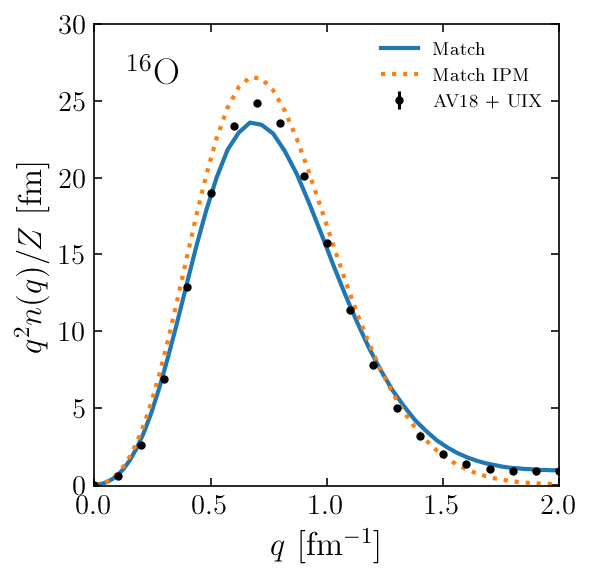

In [12]:
compare_vmc_match('O16', 8, x_limits=(0,2), y_limits=(-0.1, 30),
                  y_scale='linear')

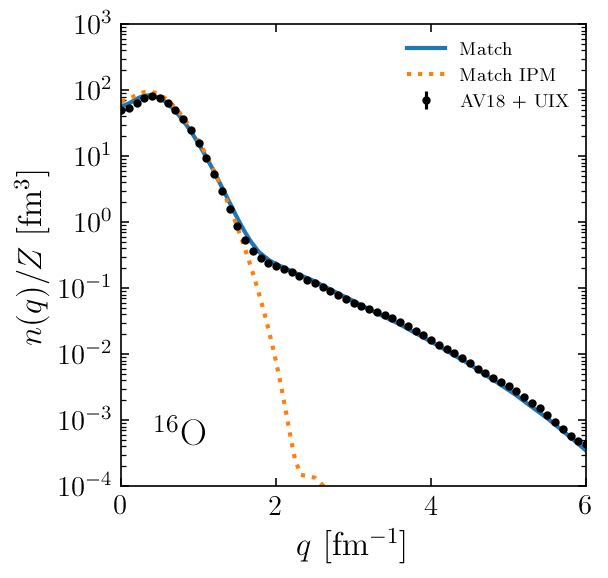

In [13]:
compare_vmc_match('O16', 8, y_scale='log')

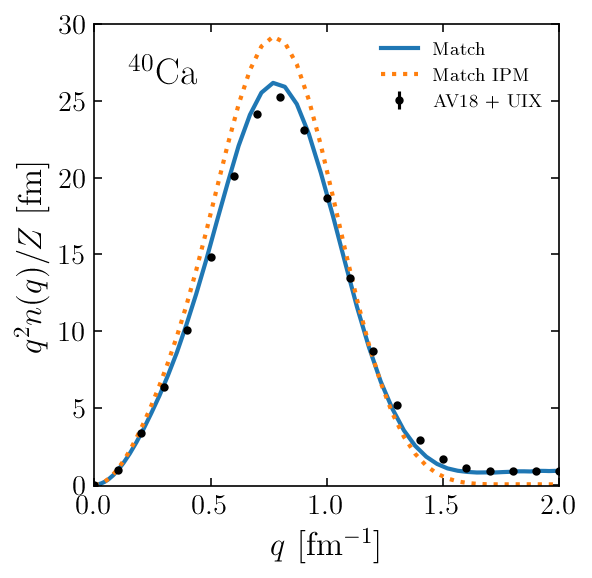

In [14]:
compare_vmc_match('Ca40', 20, x_limits=(0,2), y_limits=(-0.1, 30),
                  y_scale='linear')

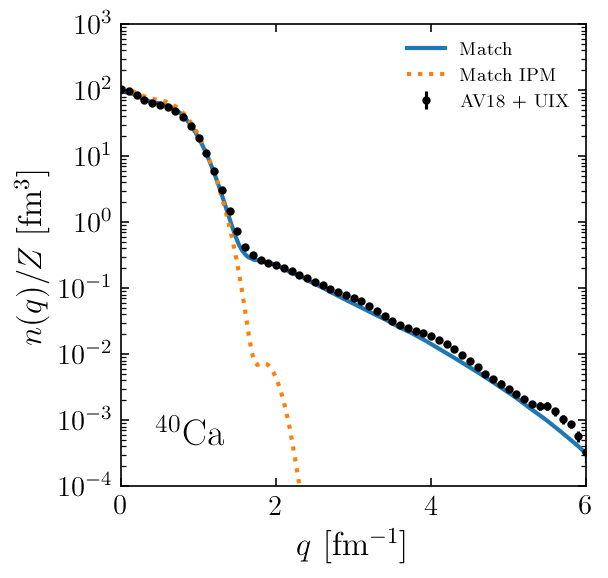

In [15]:
compare_vmc_match('Ca40', 20, y_scale='log')